# Assignment 3

## Instructions
- Run this notebook on ```Google Colab(preferable)```
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells. 

## Packages Used
- sklearn [link](https://scikit-learn.org/)
- Keras [link](https://keras.io/guides/)

## Submission
- Rename the notebook to `<roll_number>_Assignment3_Q3.ipynb`.


## Question 3
Fake news is a widespread problem and there are many methods for combating it.
You have to build a fake news detection system using a ML model. Train any ML model (ANN, LSTM) over the given Dataset.
The dataset has short statements spoken by people and has the meta-information and corresponding label for those sentences. 
Your target is label column which has 6 labels(in the increasing order of truthfullness): pants-fire, false, barely-true, half-true, mostly-true, true.

The features are 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'venue' and the target is column "label".

The statement is made by speaker whose job, party are given along with 6 columns which are an account of the  type of news(labels) the person has shared before. 
The person who has shared fake content before is likely to share it in future and this can be accounted by the ML model as a feature. Column barely_true_c contains how many barely_true news has the speaker shared (and so is with column X_c, value of X_c is number of X the person shared).


You have to perform two tasks:
* task1: Binary classification <br>
Classify the given news as true/false. Take the labels pants-fire, false, barely-true as false and rest (half-true, mostly-true, true) as true.
* task2: Six-way classification <br>
Classify the given news into six-classes "pants-fire, false, barely-true, half-true, mostly-true, true".

For each of the tasks:
1) Experiment with depth of network and try to fine-tune hyperparameters reporting your observations. <br>
2) Report the accuracy, f1-score, confusion matrix on train, val and test sets. <br>
3) Experiment with bag-of-words, glove and bert embeddings(code given in the below notebook) and report results. <br> Comment on what is the affect of embedding on the results.

The pre-processing code is provided, you need to write the training and test.

Note: You are supposed to train on trainset, fine-tune on val and just eval on test set. If found that you trained on val/test sets, the penalty will be incurred.

In [ ]:
# !pip install numpy
# !pip install tensorflow
# !pip install re
# !pip install nltk
# !pip install keras
# !pip install sklearn

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from tensorflow import keras  #feel free to use any other library
import numpy as np

import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('q3_data/train.csv')
val = pd.read_csv('q3_data/val.csv')
test = pd.read_csv('q3_data/test.csv')

In [ ]:
# Dropping the 'id' column
train.drop('id', axis = 1, inplace = True)
test.drop('id', axis = 1, inplace = True)
val.drop('id', axis = 1, inplace = True)

In [ ]:
train.head(5)

label                                          statement  \
0        False  Says the Annies List political group supports ...   
1    half-true  When did the decline of coal start? It started...   
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3        False  Health care reform legislation is likely to ma...   
4    half-true  The economic turnaround started at the end of ...   

                              subject         speaker                   job  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true_c  false_c  half_true_c  mostly_true_c  \
0     Texas  republican              0        1            0              0   
1  Virginia    democrat              0        0            1              1   
2  Illinois    democrat             70       71          160            163   
3       NaN        none              7       19            3              5   
4   Florida    democrat             15        9           20             19   

   pants_on_fire_c                venue  
0                0             a mailer  
1                0      a floor speech.  
2                9               Denver  
3               44       a news release  
4                2  an interview on CNN

In [ ]:
# Checking the shape of data
print(train.shape)
print(val.shape)
print(test.shape)

(10269, 13)
(1284, 13)
(1283, 13)


## Clean and pre-process data
* Replace missing values
* Remove numbers and special characters
* Convert to upper-case

We experiment with two types of processing, one directly appending the other attributes like subject, job, state, party to sentence and then applying bag of words on it.

Other being encoding sentence with glove embeddings and passing just that.

In [ ]:

def dataPreprocessing(data):
    '''Function for cleaning the dataset
    '''
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = statement.split()
        
        # you can experiment with any other stemmers
        ps = PorterStemmer()
        statement = [ps.stem(word) for word in statement if not word in set(stopwords.words('english'))] # Stemming the dataset and removing stopwords
        statement = ' '.join(statement)
        subject = data['subject'][x].replace(',', ' ')
        speaker = data['speaker'][x]
        job = data['job'][x].lower()
        # job = job.replace(' ', '-')
        state = data['state'][x].lower()
        party = data['party'][x].lower()
        corpus.append(statement + ' '  + subject + ' ' + job + ' ' + state + ' ' + party)
    return corpus

In [ ]:
x_train = dataPreprocessing(train)
x_val = dataPreprocessing(val) 
x_test = dataPreprocessing(test) 

In [ ]:
len(x_train), len(x_val), len(x_test)

(10269, 1284, 1283)

In [ ]:
x_train[0]

'say anni list polit group support third trimest abort demand abortion state representative texas republican'

In [ ]:
corpus = x_train + x_val + x_test

## Using bag-of-words embedding


In [ ]:
# Converting the corpus into bag-of-words
cv = CountVectorizer(max_features = 8000)
X = cv.fit_transform(corpus).toarray()

In [ ]:
X.shape

(12836, 8000)

In [ ]:
train.columns

Index(['label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
       'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'venue'],
      dtype='object')

In [ ]:
# Selecting the columns 'barely_true_c',	'false_c',	'half_true_c',	'mostly_true_c',	'pants_on_fire_c'
label_cols = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c']
x_train2 = train[label_cols]
x_val2 = val[label_cols]
x_test2 = test[label_cols]

In [ ]:
x_train2

barely_true_c  false_c  half_true_c  mostly_true_c  pants_on_fire_c
0                  0        1            0              0                0
1                  0        0            1              1                0
2                 70       71          160            163                9
3                  7       19            3              5               44
4                 15        9           20             19                2
...              ...      ...          ...            ...              ...
10264              0        1            1              1                0
10265              0        0            0              1                0
10266              4       11            5              3                3
10267              3        1            3              0                0
10268              0        1            1              0                2

[10269 rows x 5 columns]

In [ ]:
# Stacking x_train and x_train2 horizontally
x_train_bow = np.hstack((X[:len(x_train)], x_train2))
x_val_bow = np.hstack((X[len(x_train):len(x_train)+len(x_val)], x_val2))
x_test_bow = np.hstack((X[len(x_train)+len(x_val):], x_test2))

In [ ]:
x_train_bow.shape

(10269, 8005)

In [ ]:
x_train_bow[0]

array([0, 0, 0, ..., 0, 0, 0])

## Use of Glove Embedding


download glove embeddings from 'https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip'
and place in your current working folder


In [ ]:
!wget 'https://nlp.stanford.edu/data/glove.6B.zip'

--2022-04-12 18:28:55--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-12 18:28:55--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.04MB/s    in 2m 40s  

2022-04-12 18:31:35 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip "glove.6B.zip" -d "glove"

Archive:  glove.6B.zip
  inflating: glove/glove.6B.50d.txt  
  inflating: glove/glove.6B.100d.txt  
  inflating: glove/glove.6B.200d.txt  
  inflating: glove/glove.6B.300d.txt  


In [ ]:
emmbed_dict = {}
with open('glove/glove.6B.200d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    emmbed_dict[word]=vector


In [ ]:
emmbed_dict['oov'] = np.zeros(200)

In [ ]:
# emmbed_dict['prison'].shape

In [ ]:
!pip install sentence_transformers

     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 33.6 MB/s 
     |████████████████████████████████| 1.2 MB 37.8 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 47.3 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 6.5 MB 37.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=897221b892ce534f9389162d179fa582fd732b230e8aa174da63f0dbebeef23e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
def dataPreprocessing_glove(data):
    corpus = []
    # Missing values
    data["job"].fillna("no-job", inplace = True)
    data["state"].fillna("no-state", inplace = True)

    for x in range(data.shape[0]):
        statement = re.sub('[^a-zA-Z]', ' ', data['statement'][x]) # Removing all numbers and special characters
        statement = statement.lower() # Converting uppercase to lowercase
        statement = word_tokenize(statement)

        embed_statement = []
        for w in statement:
            if w in emmbed_dict:
                embed_statement.append(emmbed_dict[w])
            else:
                embed_statement.append(emmbed_dict['oov'])
         
        # bonus: Think how you can encode the below features(hint: look upon label encoding or training your own word2vec or any other embedding model)
    
#         subject = data['subject'][x].replace(',', ' ')
#         speaker = data['speaker'][x]
#         job = data['job'][x].lower()
#         # job = job.replace(' ', '-')
#         state = data['state'][x].lower()
#         party = data['party'][x].lower()
        corpus.append(embed_statement)
    
    return np.array(corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
x_train_glove = dataPreprocessing_glove(train)
x_val_glove = dataPreprocessing_glove(val) 
x_test_glove = dataPreprocessing_glove(test) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# from keras.preprocessing.sequence import pad_sequences
xtt = []
for x in x_train_glove:
  # print(type(x))
  if(len(x) < 40):
    temp = [np.zeros(200)] * (40 - len(x))
    x = x + temp
  elif len(x) >40:
    x=x[:40]
  # temp = pad_sequences(x, maxlen=50, padding='post',value = np.zeros(200)))
  xtt.append(np.array(x).flatten())

xtt = np.array(xtt)
# xtt.reshape((xtt.shape[0],1))


In [ ]:
xtt.shape

(10269, 8000)

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
xtv = []
for x in x_val_glove:
  # print(type(x))
  if(len(x) < 40):
    temp = [np.zeros(200)] * (40 - len(x))
    x = x + temp
  elif len(x) >40:
    x=x[:40]
  # temp = pad_sequences(x, maxlen=50, padding='post',value = np.zeros(200)))
  xtv.append(np.array(x).flatten())

xtv = np.array(xtv)
# xtv.reshape(xtv.shape[0],1)


In [ ]:
# from keras.preprocessing.sequence import pad_sequences
xtte = []
for x in x_test_glove:
  # print(type(x))
  if(len(x) < 40):
    temp = [np.zeros(200)] * (40 - len(x))
    x = x + temp
  elif len(x) >40:
    x=x[:40]
  # temp = pad_sequences(x, maxlen=50, padding='post',value = np.zeros(200)))
  xtte.append(np.array(x).flatten())

xtte = np.array(xtte)
# xtte.reshape(xtte.shape[0],1)

In [ ]:
# for i in xtt:
#   print(i.shape)

In [ ]:
x_train_glove = np.hstack((xtt, x_train2))
x_val_glove = np.hstack((xtv, x_val2))
x_test_glove = np.hstack((xtte, x_test2))

In [ ]:
x_train_glove.shape

(10269, 8005)

## Use of bert embeddings
note: we used our pre-processed code for bow which has the attributed appended to end the end of sentence. 

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

x_train_bert = np.hstack((model.encode(x_train), x_train2))
x_val_bert = np.hstack((model.encode(x_val), x_val2))
x_test_bert = np.hstack((model.encode(x_test), x_test2))

Now use the above 3 types of embedded inputs(bow, glove, bert embeddings) for the 2 classification tasks and compare their outputs


In [ ]:
x_train_bert.shape

(10269, 389)

# Six-way classification

## Preprocessing

In [ ]:
num_classes = 6
# Preprocessing function for the labels
def categorize(data):
    y = data["label"].tolist()

    # Encoding the Dependent Variable
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)

    # Converting to binary class matrix
    y = np_utils.to_categorical(y, num_classes)
    return y

In [ ]:
y_train_six_way = categorize(train)
y_test_six_way = categorize(test)
y_val_six_way = categorize(val)

Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


## Model

In [ ]:
len(x_train_glove[0])

8005

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
class six_model:
  def __init__(self,n,m):
    self.model = keras.Sequential()
    self.model.add(keras.layers.Embedding(n,50 , input_length=m))
    self.model.add(keras.layers.Dense(100, activation='relu'))
    # self.model.add(keras.layers.Dense(150,activation='relu'))
    self.model.add(keras.layers.Dropout(0.35))
    self.model.add(keras.layers.LSTM(128))
    self.model.add(keras.layers.Dropout(0.4))
    self.model.add(keras.layers.Dense(200,activation='relu'))
    # self.model.add(keras.layers.Dense(36,activation='relu'))
    # self.model.add(keras.layers.Dense(15,activation='relu'))
    # self.model.add(keras.layers.Dropout(0.5))
    self.model.add(keras.layers.Dense(6, activation = 'softmax'))
    opti = keras.optimizers.SGD(learning_rate = 0.01)
    self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = 'adam', metrics=['accuracy'])
  def train(self,x_t , x_v):
    self.model.fit(x_t,y_train_six_way , epochs = 6, batch_size =64, validation_data =( x_v , y_val_six_way))
  def test(self,xt):
    y_pred = self.model.predict(xt, verbose = 0)
    # print(self.model.evaluate(xt , y_test_six_way)[1])
    y_pred = np.argmax(y_pred,axis=1)
    y_t = np.argmax(y_test_six_way,axis=1)
    print('Accuracy - score: ', accuracy_score(y_t, y_pred))
    print('F1 - score: ', f1_score(y_t, y_pred, average="micro"))
    cm = confusion_matrix(y_t, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


Epoch 1/6
161/161 [==============================] - 17s 82ms/step - loss: 1.7359 - accuracy: 0.2267 - val_loss: 1.6263 - val_accuracy: 0.3006
Epoch 2/6
161/161 [==============================] - 12s 77ms/step - loss: 1.4425 - accuracy: 0.3766 - val_loss: 1.3609 - val_accuracy: 0.4073
Epoch 3/6
161/161 [==============================] - 12s 76ms/step - loss: 1.3580 - accuracy: 0.3989 - val_loss: 1.3259 - val_accuracy: 0.4206
Epoch 4/6
161/161 [==============================] - 12s 77ms/step - loss: 1.3305 - accuracy: 0.4176 - val_loss: 1.3242 - val_accuracy: 0.4081
Epoch 5/6
161/161 [==============================] - 13s 78ms/step - loss: 1.3167 - accuracy: 0.4241 - val_loss: 1.3067 - val_accuracy: 0.4221
Epoch 6/6
161/161 [==============================] - 12s 77ms/step - loss: 1.3113 - accuracy: 0.4187 - val_loss: 1.2905 - val_accuracy: 0.4400
Accuracy - score:  0.4224473889321902
F1 - score:  0.4224473889321902


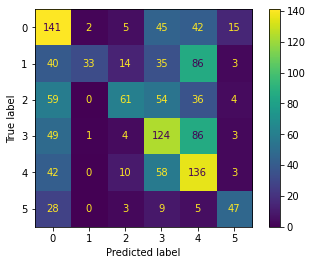

In [ ]:
bert_model = six_model(x_train_bert.shape[0],x_train_bert.shape[1])
bert_model.train(x_train_bert,x_val_bert)
bert_model.test(x_test_bert)

Epoch 1/6
161/161 [==============================] - 187s 1s/step - loss: 1.7414 - accuracy: 0.2172 - val_loss: 1.6651 - val_accuracy: 0.2555
Epoch 2/6
161/161 [==============================] - 184s 1s/step - loss: 1.4753 - accuracy: 0.3543 - val_loss: 1.3942 - val_accuracy: 0.3917
Epoch 3/6
161/161 [==============================] - 183s 1s/step - loss: 1.3594 - accuracy: 0.4015 - val_loss: 1.3262 - val_accuracy: 0.4019
Epoch 4/6
161/161 [==============================] - 183s 1s/step - loss: 1.3354 - accuracy: 0.4063 - val_loss: 1.3219 - val_accuracy: 0.4174
Epoch 5/6
161/161 [==============================] - 183s 1s/step - loss: 1.3233 - accuracy: 0.4147 - val_loss: 1.2995 - val_accuracy: 0.4268
Epoch 6/6
161/161 [==============================] - 184s 1s/step - loss: 1.3109 - accuracy: 0.4173 - val_loss: 1.3048 - val_accuracy: 0.4206
Accuracy - score:  0.4162120031176929
F1 - score:  0.4162120031176929


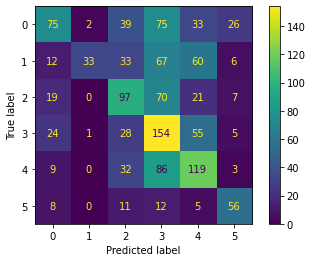

In [ ]:
bow_model = six_model(x_train_bow.shape[0],x_train_bow.shape[1])
bow_model.train(x_train_bow,x_val_bow)
bow_model.test(x_test_bow)


Epoch 1/6
161/161 [==============================] - 186s 1s/step - loss: 1.7458 - accuracy: 0.2117 - val_loss: 1.6668 - val_accuracy: 0.2827
Epoch 2/6
161/161 [==============================] - 187s 1s/step - loss: 1.4726 - accuracy: 0.3665 - val_loss: 1.3679 - val_accuracy: 0.3941
Epoch 3/6
161/161 [==============================] - 184s 1s/step - loss: 1.3575 - accuracy: 0.4073 - val_loss: 1.3215 - val_accuracy: 0.4206
Epoch 4/6
161/161 [==============================] - 184s 1s/step - loss: 1.3342 - accuracy: 0.4114 - val_loss: 1.3218 - val_accuracy: 0.4237
Epoch 5/6
161/161 [==============================] - 184s 1s/step - loss: 1.3196 - accuracy: 0.4242 - val_loss: 1.2999 - val_accuracy: 0.4315
Epoch 6/6
161/161 [==============================] - 184s 1s/step - loss: 1.3038 - accuracy: 0.4310 - val_loss: 1.3076 - val_accuracy: 0.4252
Accuracy - score:  0.421667965705378
F1 - score:  0.421667965705378


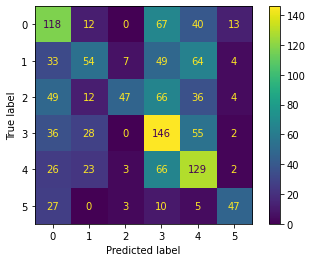

In [ ]:
glove_model = six_model(x_train_glove.shape[0],x_train_glove.shape[1])
glove_model.train(x_train_glove,x_val_glove)
glove_model.test(x_test_glove)

In [ ]:
# class bert_model:
#   def __init__(self):
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(200, activation='relu'))
#     self.model.add(keras.layers.Dense(150,activation='relu'))
#     self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(6, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(x_train_bert,y_train_six_way , epochs = 29, batch_size =64, validation_data =( x_val_bert , y_val_six_way))
#   def test(self):
#     y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_bert , y_test_six_way))
#     # print('Accuracy - score: ', accuracy_score(y_test_six_way, y_pred))
#     # print('F1 - score: ', f1_score(y_test_six_way, y_pred))
#     # cm = confusion_matrix(y_test_six_way, y_pred)
#     # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     # disp.plot()


In [ ]:
# b = bert_model()
# b.train()
# b.test()

In [ ]:
# class bow_model:
#   def __init__(self):
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(7500, activation='relu'))
#     self.model.add(keras.layers.Dense(3500,activation='relu'))
#     self.model.add(keras.layers.Dense(2000,activation='relu'))
#     self.model.add(keras.layers.Dense(750,activation='relu'))
#     self.model.add(keras.layers.Dense(360,activation='relu'))
#     self.model.add(keras.layers.Dense(150,activation='relu'))
#     self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(6, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(x_train_bow,y_train_six_way , epochs = 20, batch_size =64, validation_data =( x_val_bow , y_val_six_way))
#   def test(self):
#     # y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_bow , y_test_six_way))

In [ ]:
# bo = bow_model()
# bo.train()
# bo.test()

In [ ]:
# class glove_model:
#   def __init__(self):
#     # self.model = keras.Sequential()
#     # # self.model.add(keras.layers.Dense(8000, activation='relu'))
#     # self.model.add(keras.layers.Dense(7500, activation='relu'))
#     # # self.model.add(keras.layers.Dense(3500,activation='relu'))
#     # self.model.add(keras.layers.Dense(2000,activation='relu'))
#     # # self.model.add(keras.layers.Dense(750,activation='relu'))
#     # self.model.add(keras.layers.Dense(360,activation='relu'))
#     # # self.model.add(keras.layers.Dense(150,activation='relu'))
#     # self.model.add(keras.layers.Dense(75,activation='relu'))
#     # self.model.add(keras.layers.Dense(36,activation='relu'))
#     # self.model.add(keras.layers.Dense(15,activation='relu'))
#     # self.model.add(keras.layers.Dense(6, activation = 'softmax'))
#     # opti = keras.optimizers.SGD(learning_rate = 0.01)
#     # self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(7500, activation='tanh'))
#     # self.model.add(keras.layers.Dense(3500,activation='tanh'))
#     self.model.add(keras.layers.Dense(2000,activation='tanh'))
#     # self.model.add(keras.layers.Dense(750,activation='tanh'))
#     self.model.add(keras.layers.Dense(360,activation='tanh'))
#     # self.model.add(keras.layers.Dense(150,activation='relu'))
#     # self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     # self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(6, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(x_train_glove,y_train_six_way , epochs = 10, batch_size =128, validation_data =( x_val_glove , y_val_six_way))
#   def test(self):
#     # y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_glove , y_test_six_way))

In [ ]:
# g= glove_model()
# g.train()
# g.test()

In [ ]:
# ## write your code here
# # Initialize hyperparameters
# # Create model
# # train
# # test
# # report accuracy, f1-score and confusion matrix

# class glove_model:
#   def __init__(self):
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Embedding((10269* 6),100))
#     self.model.add(keras.layers.LSTM(units = 100))
#     self.model.add(keras.layers.Dense(units = 20))
#     self.model.add(keras.layers.Dense(units = 6 , activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(np.asarray(x_train_glove).astype('float32') , y_train_six_way, epochs = 10, batch_size = 128,validation_data=(np.asarray(x_val_glove).astype('float32'), y_val_six_way))
  
#   def test(self):
#     y_pred = self.model.predict(np.asarray(x_test_glove).astype('float32'), verbose = 0)
#     print('Accuracy - score: ', accuracy_score(y_test_six_way, y_pred))
#     print('F1 - score: ', f1_score(y_test_six_way, y_pred))
#     cm = confusion_matrix(y_test_six_way, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()



# class bow_model:
#   def __init__(self):
#     # self.model = keras.Sequential()
#     # self.model.add(keras.layers.Embedding((10269* 6),100))
#     # self.model.add(keras.layers.LSTM(units = 100))
#     # self.model.add(keras.layers.Dense(units = 20))
#     # self.model.add(keras.layers.Dense(units = 6 , activation = 'softmax'))
#     # opti = keras.optimizers.SGD(learning_rate = 0.01)
#     # self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
#     input1 = keras.layers.Input(shape = (10269,8000,1))
#     input2 = keras.layers.Input(shape= (5,))
#     out = keras.layers.LSTM(128)(input1)
#     out = keras.layers.LSTM(1)(out)
#     input3 =keras.layers.Concatenate(axis = 1)([out,input2])
#     out_final = keras.layers.Dense(6,activation = 'softmax')(input3)
#     self.model = keras.models.Model(inputs = [input1,input2], output = out_final)
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
     
  
#   def train(self):
#     self.model.fit([x_train_bow[:8001].reshape(x_train_bow.shape[0],8000,1),x_train_bow[8001:]] , y_train_six_way, epochs = 10, batch_size = 128,validation_data=([x_train_bow[:8001].reshape(x_train_bow.shape[0],8000,1),x_train_bow[8001:]], y_val_six_way))
  
#   def test(self):
#     y_pred = self.model.predict([x_test_bow[:8001].reshape(x_test_bow.shape[0],8000,1),x_train_bow[8001:]])
#     print('Accuracy - score: ', accuracy_score(y_test_six_way, y_pred))
#     print('F1 - score: ', f1_score(y_test_six_way, y_pred))
#     cm = confusion_matrix(y_test_six_way, y_pred)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot()



In [ ]:
# b = bow_model()
# b.train()
# b.test()

In [ ]:
# # Gove accuracy
# gl = glove_model()
# gl.train()
# gl.test()

# Binary Classification

## Preprocessing

In [ ]:
num_classes = 2

In [ ]:
# Function for preprocessing labels
def dataPreprocessingBinary(data):
    y = data["label"].tolist()

    # Changing the 'half-true', 'mostly-true', barely-true', 'pants-fire' labels to True/False for Binary Classification
    for x in range(len(y)):
        if(y[x] == 'half-true'):
            y[x] = 'True'
        elif(y[x] == 'mostly-true'):
            y[x] = 'True'
        elif(y[x] == 'barely-true'):
            y[x] = 'False'
        elif(y[x] == 'pants-fire'):
            y[x] = 'False'

    # Converting the lables into binary class matrix
    labelencoder_y = LabelEncoder()
    y = labelencoder_y.fit_transform(y)
    y = np_utils.to_categorical(y, num_classes)
    return y

In [ ]:
y_train_binary = dataPreprocessingBinary(train)
y_test_binary = dataPreprocessingBinary(test)
y_val_binary = dataPreprocessingBinary(val)

In [ ]:
y_train_binary.shape

(10269, 2)

In [ ]:
y_train_binary[0]

array([1., 0.], dtype=float32)

## Model
Build a model and pass bow, glove and bert embedded inputs: x_train_bow, x_train_glove, x_train_bert(similarly validate for val and report results on test)


In [ ]:
class two_model:
  def __init__(self,n,m):
    self.model = keras.Sequential()
    self.model.add(keras.layers.Embedding(n,50 , input_length=m))
    self.model.add(keras.layers.Dense(100, activation='relu'))
    # self.model.add(keras.layers.Dense(150,activation='relu'))
    self.model.add(keras.layers.Dropout(0.35))
    self.model.add(keras.layers.LSTM(128))
    self.model.add(keras.layers.Dropout(0.4))
    self.model.add(keras.layers.Dense(200,activation='relu'))
    # self.model.add(keras.layers.Dense(36,activation='relu'))
    # self.model.add(keras.layers.Dense(15,activation='relu'))
    self.model.add(keras.layers.Dropout(0.4))
    self.model.add(keras.layers.Dense(2, activation = 'softmax'))
    opti = keras.optimizers.SGD(learning_rate = 0.01)
    self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = 'adam', metrics=['accuracy'])
  def train(self,x_t , x_v):
    self.model.fit(x_t,y_train_binary , epochs = 6, batch_size =128, validation_data =( x_v , y_val_binary))
  def test(self,xt):
    y_pred = self.model.predict(xt, verbose = 0)
    # print(self.model.evaluate(xt , y_test_six_way)[1])
    y_pred = np.argmax(y_pred,axis=1)
    y_t = np.argmax(y_test_binary,axis=1)
    print('Accuracy - score: ', accuracy_score(y_t, y_pred))
    print('F1 - score: ', f1_score(y_t, y_pred))
    cm = confusion_matrix(y_t, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


Epoch 1/6
81/81 [==============================] - 11s 111ms/step - loss: 0.6832 - accuracy: 0.5651 - val_loss: 0.6832 - val_accuracy: 0.5615
Epoch 2/6
81/81 [==============================] - 8s 97ms/step - loss: 0.6717 - accuracy: 0.5855 - val_loss: 0.6781 - val_accuracy: 0.5693
Epoch 3/6
81/81 [==============================] - 8s 97ms/step - loss: 0.6661 - accuracy: 0.5942 - val_loss: 0.6716 - val_accuracy: 0.5670
Epoch 4/6
81/81 [==============================] - 8s 97ms/step - loss: 0.6578 - accuracy: 0.6009 - val_loss: 0.6192 - val_accuracy: 0.6316
Epoch 5/6
81/81 [==============================] - 8s 98ms/step - loss: 0.5684 - accuracy: 0.6715 - val_loss: 0.5291 - val_accuracy: 0.6776
Epoch 6/6
81/81 [==============================] - 8s 98ms/step - loss: 0.5291 - accuracy: 0.6942 - val_loss: 0.5242 - val_accuracy: 0.6760
Accuracy - score:  0.6936866718628215
F1 - score:  0.7768313458262351


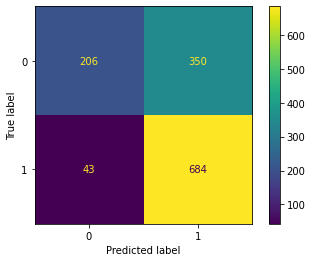

In [ ]:
bert_model = two_model(x_train_bert.shape[0],x_train_bert.shape[1])
bert_model.train(x_train_bert,x_val_bert)
bert_model.test(x_test_bert)

Epoch 1/6
81/81 [==============================] - 123s 1s/step - loss: 0.6829 - accuracy: 0.5700 - val_loss: 0.6810 - val_accuracy: 0.5646
Epoch 2/6
81/81 [==============================] - 120s 1s/step - loss: 0.6704 - accuracy: 0.5836 - val_loss: 0.6750 - val_accuracy: 0.5755
Epoch 3/6
81/81 [==============================] - 121s 1s/step - loss: 0.6670 - accuracy: 0.5946 - val_loss: 0.6706 - val_accuracy: 0.5662
Epoch 4/6
81/81 [==============================] - 121s 1s/step - loss: 0.6568 - accuracy: 0.5948 - val_loss: 0.6335 - val_accuracy: 0.5927
Epoch 5/6
81/81 [==============================] - 120s 1s/step - loss: 0.5818 - accuracy: 0.6625 - val_loss: 0.5380 - val_accuracy: 0.6636
Epoch 6/6
81/81 [==============================] - 121s 1s/step - loss: 0.5329 - accuracy: 0.6920 - val_loss: 0.5220 - val_accuracy: 0.6768
Accuracy - score:  0.6921278254091972
F1 - score:  0.7661338069863824


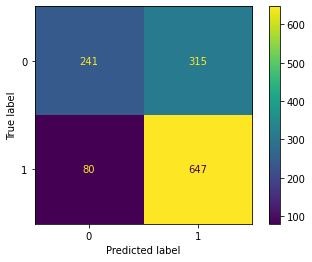

In [ ]:
bow_model = two_model(x_train_bow.shape[0],x_train_bow.shape[1])
bow_model.train(x_train_bow,x_val_bow)
bow_model.test(x_test_bow)

Epoch 1/6
81/81 [==============================] - 123s 1s/step - loss: 0.6809 - accuracy: 0.5683 - val_loss: 0.6823 - val_accuracy: 0.5615
Epoch 2/6
81/81 [==============================] - 120s 1s/step - loss: 0.6700 - accuracy: 0.5893 - val_loss: 0.6729 - val_accuracy: 0.5654
Epoch 3/6
81/81 [==============================] - 120s 1s/step - loss: 0.6665 - accuracy: 0.5948 - val_loss: 0.6682 - val_accuracy: 0.5755
Epoch 4/6
81/81 [==============================] - 120s 1s/step - loss: 0.6642 - accuracy: 0.5932 - val_loss: 0.6597 - val_accuracy: 0.5623
Epoch 5/6
81/81 [==============================] - 121s 1s/step - loss: 0.5947 - accuracy: 0.6425 - val_loss: 0.5345 - val_accuracy: 0.6667
Epoch 6/6
81/81 [==============================] - 121s 1s/step - loss: 0.5330 - accuracy: 0.6935 - val_loss: 0.5210 - val_accuracy: 0.6737
Accuracy - score:  0.6905689789555729
F1 - score:  0.7745599091425326


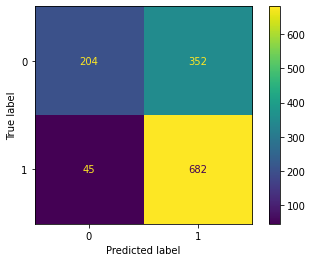

In [ ]:
glove_model = two_model(x_train_glove.shape[0],x_train_glove.shape[1])
glove_model.train(x_train_glove,x_val_glove)
glove_model.test(x_test_glove)

In [ ]:
# class bert_model2:
#   def __init__(self):
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(200, activation='relu'))
#     self.model.add(keras.layers.Dense(150,activation='relu'))
#     self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(2, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(x_train_bert,y_train_binary , epochs = 29, batch_size =64, validation_data =( x_val_bert , y_val_binary))
#   def test(self):
#     # y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_bert , y_test_binary))

In [ ]:
# b2 = bert_model2()
# b2.train()
# b2.test()

In [ ]:
# ## write your code here
# # Initialize hyperparameters
# # Create model
# # train
# # test
# # report accuracy, f1-score and confusion matrix
# class bow_model2:
#   def __init__(self):
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(7500, activation='relu'))
#     self.model.add(keras.layers.Dense(3500,activation='relu'))
#     self.model.add(keras.layers.Dense(2000,activation='relu'))
#     self.model.add(keras.layers.Dense(750,activation='relu'))
#     self.model.add(keras.layers.Dense(360,activation='relu'))
#     self.model.add(keras.layers.Dense(150,activation='relu'))
#     self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(2, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     self.model.fit(x_train_bow,y_train_binary , epochs = 20, batch_size =64, validation_data =( x_val_bow , y_val_binary))
#   def test(self):
#     # y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_bow , y_test_binary))

In [ ]:
# bo2 = bow_model2()
# bo2.train()
# bo2.test()

In [ ]:
# class glove_model2:
#   def __init__(self):
#     # self.model = keras.Sequential()
#     # # self.model.add(keras.layers.Dense(8000, activation='relu'))
#     # self.model.add(keras.layers.Dense(7500, activation='relu'))
#     # # self.model.add(keras.layers.Dense(3500,activation='relu'))
#     # self.model.add(keras.layers.Dense(2000,activation='relu'))
#     # # self.model.add(keras.layers.Dense(750,activation='relu'))
#     # self.model.add(keras.layers.Dense(360,activation='relu'))
#     # # self.model.add(keras.layers.Dense(150,activation='relu'))
#     # self.model.add(keras.layers.Dense(75,activation='relu'))
#     # self.model.add(keras.layers.Dense(36,activation='relu'))
#     # self.model.add(keras.layers.Dense(15,activation='relu'))
#     # self.model.add(keras.layers.Dense(6, activation = 'softmax'))
#     # opti = keras.optimizers.SGD(learning_rate = 0.01)
#     # self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
#     self.model = keras.Sequential()
#     self.model.add(keras.layers.Dense(7500, activation='tanh'))
#     # self.model.add(keras.layers.Dense(3500,activation='tanh'))
#     self.model.add(keras.layers.Dense(2000,activation='tanh'))
#     # self.model.add(keras.layers.Dense(750,activation='tanh'))
#     self.model.add(keras.layers.Dense(360,activation='tanh'))
#     # self.model.add(keras.layers.Dense(150,activation='relu'))
#     # self.model.add(keras.layers.Dense(75,activation='relu'))
#     self.model.add(keras.layers.Dense(36,activation='relu'))
#     # self.model.add(keras.layers.Dense(15,activation='relu'))
#     self.model.add(keras.layers.Dense(2, activation = 'softmax'))
#     opti = keras.optimizers.SGD(learning_rate = 0.01)
#     self.model.compile(loss = keras.losses.categorical_crossentropy,optimizer = opti, metrics=['accuracy'])
  
#   def train(self):
#     # self.model.fit(x_train_glove,y_train_binary , epochs = 10, batch_size =128, validation_data =( x_val_glove , y_val_binary))
#   def test(self):
#     # y_pred = self.model.predict(x_test_bert, verbose = 0)
#     print(self.model.evaluate(x_test_glove , y_test_binary))

In [ ]:
# g2 = glove_model2()
# g2.train()
# g2.test()